In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, MetaData

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
metadata = MetaData()
metadata.reflect(bind=engine)

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
#Create an Inspector and connect it to the engine
inspector = inspect(engine)

# Get a list of table names
tables = inspector.get_table_names()
print("Tables in the database:", tables)

Tables in the database: ['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

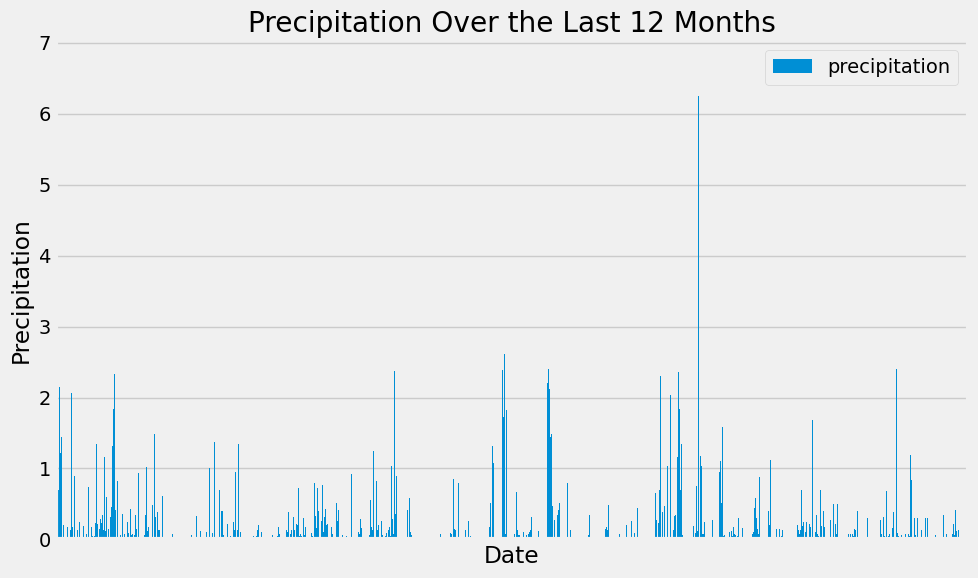

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
from datetime import datetime, timedelta #import DateTime and TimeDelta to handle dates and year calculations

#Define the date string from latest date in database
most_recent_date_str = '2017-08-23'

#Convert date to a DateTime object
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

#Calculate the date for one year before most recent date in database
one_year_before = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_before.strftime('%Y-%m-%d')).\
    order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurements_df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Set the 'date' column as the index
measurements_df.set_index('date', inplace=True)

# Sort the dataframe by date
sorted_measurements_df = measurements_df.sort_values(by='date', ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
# Plot the data
measurements_df.plot(kind='bar', figsize=(10, 6), width=1)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Over the Last 12 Months')

plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks([])  # Hides the x-axis labels to avoid clutter
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

In [ ]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = measurements_df['precipitation'].describe()

summary_statistics

# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()
print("Total number of stations:", total_stations)

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
from sqlalchemy.orm import aliased #ORM function imported in order to work across multiple tables in the database avoiding any conflicts/redundancies

#Join both Measurement and Station tables in the database using "Station" column with specific station IDs listed for each row to join data for later queries
most_active_stations = session.query( #most_active_stations = variable to store SQL query results
    Station.station,  #Matches the two station columns that exist in each database table (Measurement, Station)
    func.count(Measurement.station).label('count')
).join(
    Measurement, Station.station == Measurement.station  #Join function to produce the query, joins Measurement & Station tables
).group_by(
    Station.station #Groupby function of the two "Station" columns listed in each of the two tables (Measurement, Station)
).order_by(
    func.count(Measurement.station).desc()
).all()

for station_id, count in most_active_stations:
    print(f"Station ID: {station_id}, Count: {count}")


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query to find the highest, lowest and average temperature for station 'USC00519281'
temp_stats = session.query #temp stats = holds the query results for calculating temp max/min/avg from the database
    func.max(Measurement.tobs).label('max_temp'), #func.max calls the SQL Alchemy function "max" in order to calculate the max temp for the specific station ID; Measurement.tobs instructs the query to reference the Measurements (aka a "class") table and the "tobs" column within it
    func.min(Measurement.tobs).label('min_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == 'USC00519281').all() #filters for specific station ID identified for most active above

max_temp, min_temp, avg_temp = temperature_stats[0] #displays results
print(f"Max Temperature: {max_temp}")
print(f"Min Temperature: {min_temp}")
print(f"Average Temperature: {round(avg_temp, 2)}")


In [ ]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Filter for most active station
most_active_station_id = 'USC00519281'

temperature_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_before.strftime('%Y-%m-%d')).\
    order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the column names
temperature_df = pd.DataFrame(temperature_results, columns=['date', 'temperature'])

# Set the 'date' column as the index
temperature_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the histogram
temperature_df.plot(kind='hist', bins=12, figsize=(10, 6), alpha=0.75, color='royalblue')

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Station ' + most_active_station_id)
plt.grid(True)
plt.tight_layout()

plt.show()


# Close Session

In [ ]:
# Close Session
session.close()

In [ ]:
from flask import Flask, jsonify
import datetime
from sqlalchemy import create_engine, func
from sqlalchemy.orm import scoped_session, sessionmaker

app = Flask(__name__)

# Setup the database connection and session
engine = create_engine("sqlite:///Resources/hawaii.sqlite") 
Session = scoped_session(sessionmaker(bind=engine))

@app.route("/api/v1.0/precipitation")
def precipitation():
    session = Session()
    one_year_ago = datetime.datetime.now() - datetime.timedelta(days=365)

    # Perform the query as outlined in the notebook
    results = session.query(Measurement.date, Measurement.prcp).\
              filter(Measurement.date >= one_year_ago).all()

    precip = {date: prcp for date, prcp in results}
    session.remove()  # Properly close the session

    return jsonify(precip)

if __name__ == "__main__":
    app.run(debug=True, port=5001)




